In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

In [2]:
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)

1.7.1+cu101
0.8.2+cu101


In [3]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_cached(i)/1024**3,1)} GB\n")
        
else:
    print("# GPU is not available")

# DEVICE 0: Tesla V100-PCIE-32GB
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# DEVICE 1: Tesla V100-PCIE-32GB
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# DEVICE 2: Tesla V100-PCIE-32GB
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB



/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [4]:
# GPU 할당 변경하기
GPU_NUM = 0 # 원하는 GPU 번호 입력

device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('# Current cuda device: ', torch.cuda.current_device()) # check

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print(f"using cuda: {GPU_NUM}, {torch.cuda.get_device_name(GPU_NUM)}")

# Current cuda device:  0
using cuda: 0, Tesla V100-PCIE-32GB


In [35]:
torch.cuda.memory_allocated(0)

13312

In [267]:
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  235821 KB |    1271 MB |    2184 TB |    2184 TB |
|---------------------------------------------------------------------------|
| Active memory         |  235821 KB |    1271 MB |    2184 TB |    2184 TB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    1496 MB |    1496 MB |    1496 MB |       0 B  |
|---------------------------------------------------------------

In [17]:
from torch.utils.data import Dataset

class MnistDataset(Dataset):
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        image_values = torch.Tensor(self.data_df.iloc[index, 1:].values)/255.0
        
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
        plt.title(f"label= {self.data_df.iloc[index, 0]}")
        plt.imshow(img, interpolation="none", cmap="Blues")
        

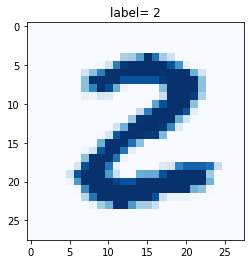

In [18]:
mnist_dataset = MnistDataset("./myo_gan/mnist_train.csv")
mnist_dataset.plot_image(25)

In [20]:
import torch.nn as nn

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,
    
    def forward(self, x):
        return x.view(*self.shape)

In [27]:
x = torch.Tensor(mnist_dataset[0][1]).cuda()
x.shape

torch.Size([784])

In [39]:
m0 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
m1 = nn.Conv2d(10, 10, kernel_size=3, stride=2)

m0_out = m0(x.view(1, 1, 28, 28))
print(m0_out.shape)

m1_out = m1(m0_out)
print(m1_out.shape)

torch.Size([1, 10, 12, 12])
torch.Size([1, 10, 5, 5])


In [45]:
class Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            
            nn.Conv2d(10, 10, kernel_size=3, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            
            View(250),
            nn.Linear(250, 10),
            nn.Sigmoid()
        )
        self.model = self.model.cuda()
        
        self.loss_function = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters())
        
        self.counter = 0
        self.progress = []
        
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        
        loss = self.loss_function(outputs, targets)
        
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            
        if (self.counter %10000 == 0):
            print("counter = ", self.counter)
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0, 1), figsize=(16, 8), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5))

In [46]:
C = Classifier()

epochs = 3

for i in range(epochs):
    print(f"epoch {i+1}/{epochs}")
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)

epoch 1/3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
epoch 2/3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch 3/3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000


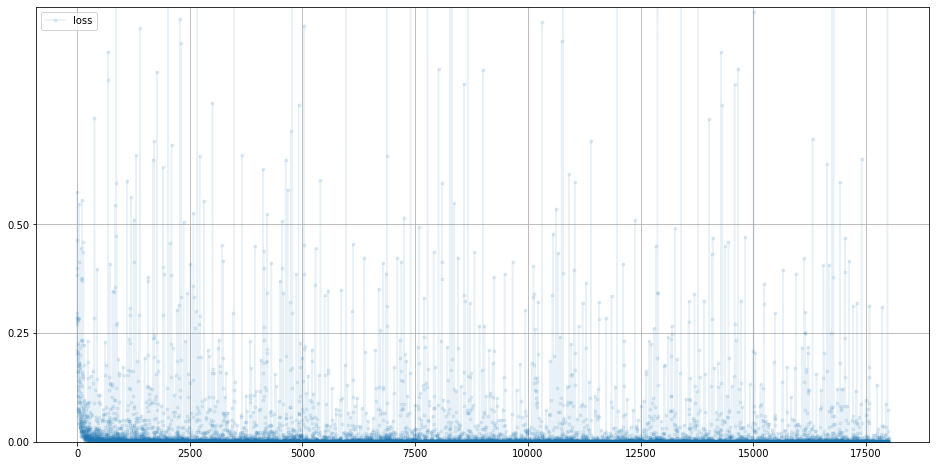

In [47]:
C.plot_progress()

In [72]:
def plot_forward(index):
    target_label = mnist_dataset[index][0]
    target_pred = C.forward(mnist_dataset[index][1].view((1, 1, 28, 28))).argmax()
    print(target_pred, target_label)

In [73]:
plot_forward(43)

tensor(9) 9


In [75]:
def crop_center(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2
    return img[starty:starty+new_height, startx:startx+new_width, :]

(218, 178, 3)


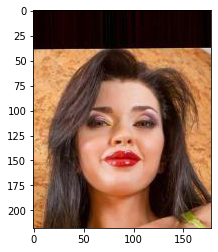

In [77]:
import h5py
with h5py.File("./myo_gan/celeba_aligned_small.h5py", "r") as file_object:
#     for group in file_object:
#         print(group)
    dataset = file_object["img_align_celeba"]
    image = np.array(dataset["77.jpg"])
    plt.imshow(image)
    
    print(image.shape)

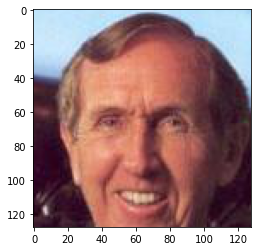

In [85]:
from torch.utils.data import Dataset

class CelebADataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, "r")
        self.dataset = self.file_object["img_align_celeba"]
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if index >= len(self.dataset):
            raise IndexError()
        img = np.array(self.dataset[f"{str(index)}.jpg"])
        img = crop_center(img, 128, 128)
        return torch.Tensor(img).permute(2,0,1).view(1,3,128,128)/255.0
    
    def plot_image(self, index):
#         img = self.dataset[f"{str(index)}.jpg"]
        img = np.array(self.dataset[f"{index}.jpg"])
        img = crop_center(img, 128, 128)
        plt.imshow(img)
        
celeba_dataset = CelebADataset("./myo_gan/celeba_aligned_small.h5py")
celeba_dataset.plot_image(20)

In [86]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.rand(size)
    return random_data

In [87]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,
        
    def forward(self, x):
        return x.view(*self.shape)

In [100]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),
            
            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        ) 
        
        self.model = self.model.cuda()
        
        self.loss_function = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    
        self.counter = 0
        self.progress = []
    
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        
        loss = self.loss_function(outputs, targets)
        
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
            
        if self.counter % 1000 == 0:
            print(f"counter = {self.counter}")
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".", grid=True, 
                yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [101]:
D = Discriminator()

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))
    pass

counter = 1000
counter = 2000
counter = 3000
counter = 4000
counter = 5000
counter = 6000
counter = 7000
counter = 8000
counter = 9000
counter = 10000
counter = 11000
counter = 12000
counter = 13000
counter = 14000
counter = 15000
counter = 16000
counter = 17000
counter = 18000
counter = 19000
counter = 20000
counter = 21000
counter = 22000
counter = 23000
counter = 24000
counter = 25000
counter = 26000
counter = 27000
counter = 28000
counter = 29000
counter = 30000
counter = 31000
counter = 32000
counter = 33000
counter = 34000
counter = 35000
counter = 36000
counter = 37000
counter = 38000
counter = 39000
counter = 40000


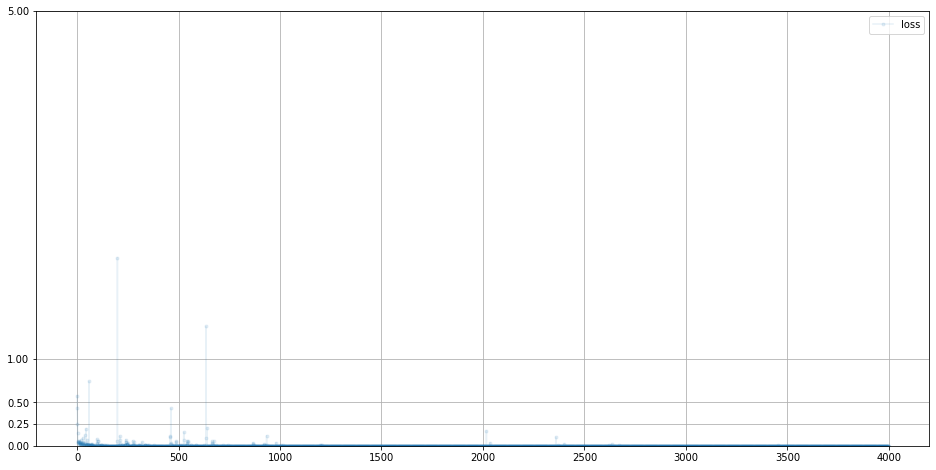

In [102]:
D.plot_progress()

In [105]:
import random

for i in range(4):
    image_data_tensor = celeba_dataset[random.randint(0, 20000)]
    print(D.forward(image_data_tensor).item())
    
for i in range(4):
    print(D.forward(generate_random_image((1, 3, 128, 128))).item())

1.0
1.0
1.0
1.0
2.0464848660139978e-07
7.531326673415606e-08
1.3483623995114158e-08
6.840105370997662e-09


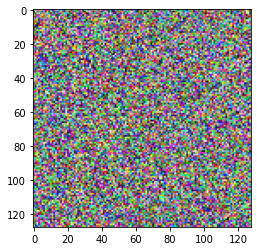

In [116]:
plt.imshow(generate_random_image((1, 3, 128, 128)).cpu().numpy()[0].swapaxes(0, 2))

In [257]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100, 3*11*11),
            nn.LeakyReLU(0.2),
            
            View((1, 3, 11, 11)),
            
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            
            nn.Sigmoid()            
        )
        self.model = self.model.cuda()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        
        self.counter = 0
        self.progress = []
        
    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)

        d_output = D.forward(g_output)

        loss = D.loss_function(d_output, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print(f"counter= {self.counter}")

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".", grid=True, 
                yticks=(0, 0.25, 0.5, 1.0, 5.0))
            

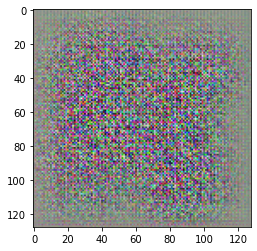

In [258]:
G = Generator()

output = G.forward(generate_random_seed(100))

img = output.detach().permute(0, 2, 3, 1).view(128, 128, 3).cpu().numpy()
plt.imshow(img)

In [259]:
#######

In [260]:
# discriminator class

# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),
            
            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.000001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [261]:

%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 18min 56s, sys: 46min 50s, total: 1h 5min 46s
Wall time: 8min 14s


In [262]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # input is a 1d array
            nn.Linear(100, 3*11*11),
            nn.LeakyReLU(0.2),
            
            # reshape to 4d
            View((1, 3, 11, 11)),
            
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.002),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.002),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            
            # output should be (1,3,128,128)
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [263]:
%%time
D = Discriminator()
G = Generator()

D.to(device)
G.to(device)

epochs = 10

images = {}
for epoch in range(epochs):
    print(f"epoch = {epoch+1}")
    
    # train Discriminator and Generator
    for image_data_tensor in celeba_dataset:
        D.train(image_data_tensor, torch.Tensor([1.0]))
        D.train(G.forward(generate_random_seed(100)).detach(), torch.Tensor([0.0]))
        G.train(D, generate_random_seed(100), torch.Tensor([1.0]))
        
    # generate images
    outputs = []
    for i in range(6):
        output = G.forward(generate_random_seed(100))
        outputs.append(output.detach().permute(0, 2, 3, 1).view(128,128,3).cpu().numpy())
    images[epoch] = outputs
        

epoch = 1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch = 2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
cou

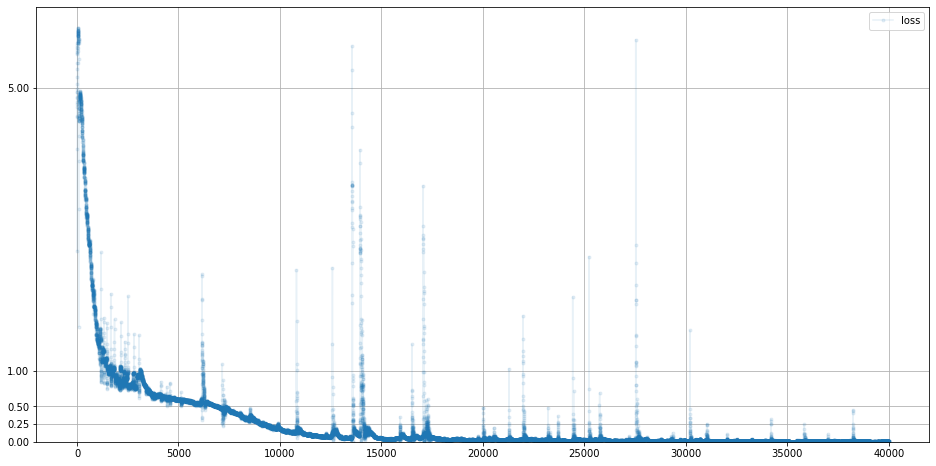

In [264]:
D.plot_progress()

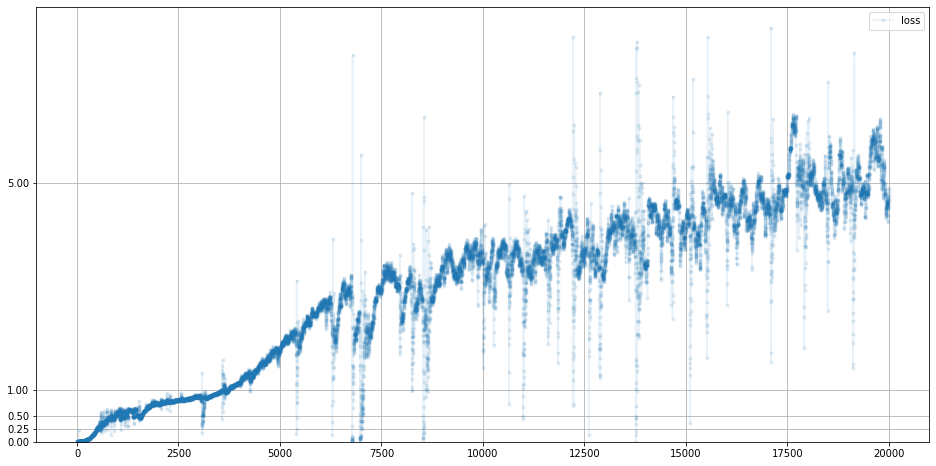

In [265]:
G.plot_progress()

In [252]:
len(images)

10

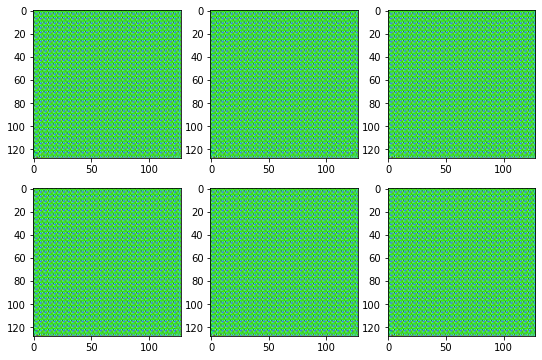

In [253]:
outputs = images[9]
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(outputs[i])

In [202]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 10

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for image_data_tensor in celeba_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

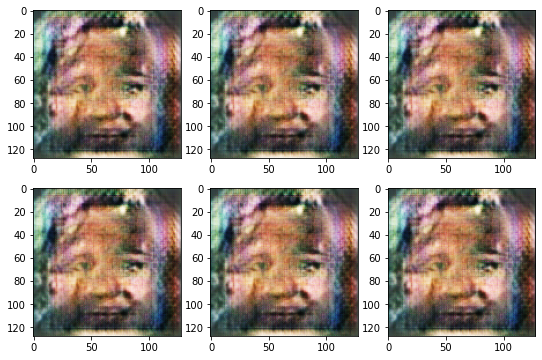

In [203]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(outputs[i])

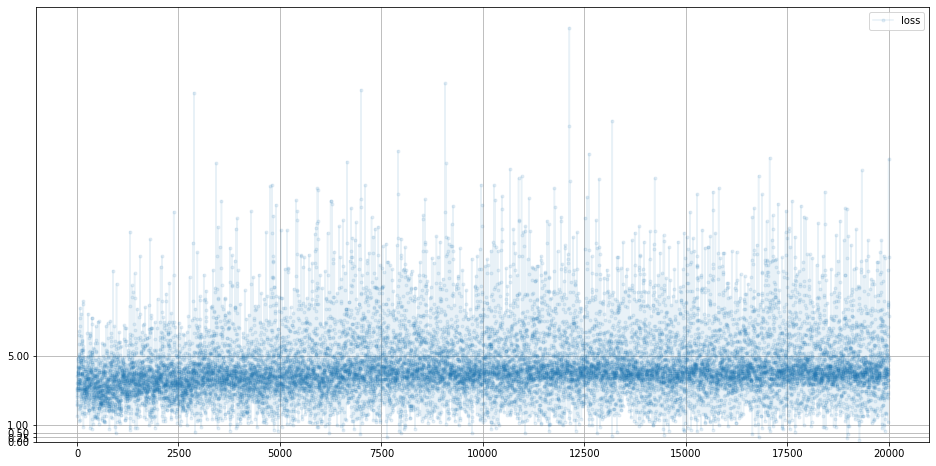

In [204]:
G.plot_progress()